# Project Description - Automatic Steel Defects classification and localization

**Introduction** <br>
This is a project of defects classification/localization for steel defects on the GC10-DET surface dataset using transfer learning. VGG16 is used for training the dataset. 

**Outline** <br>
This project will have the presentation outlined as follows,
1. Dataset visualization
2. Model training and validation
3. Model testing
4. Results evaluation
5. Model prediction

In [10]:
# Import necessary libraries

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import random
import os
from matplotlib.patches import Rectangle
from matplotlib import pyplot
from lxml import etree

# Enable Matplotlib backend for displaying static images
%matplotlib inline

import subprocess

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input

Las siguientes líneas sólo se deben ejecutar la primera vez. De esta forma se descomprimen y organizan los datos adecuadamente.

In [8]:
#!mkdir '/content/sample_data/Metal'
#!unzip -q '/content/drive/My Drive/Colab Notebooks/Computer Vision course/DL/images/Metallic database.zip' -d '/content/sample_data/Metal/images'
#!mv  -v '/content/sample_data/Metal/images/label' '/content/sample_data/Metal/label'

In [11]:
STORAGE_BUCKET = 'mia_bucket'
DATA_PATH = 'Metallic data'
LOCAL_PATH = '/tmp'
PROJECT_ID = 'MIA-DeepLearning'


# Download dataset
subprocess.call([
  'gsutil', '-m', 'cp', '-r',
  # Storage path
  os.path.join('gs://', STORAGE_BUCKET, DATA_PATH),
  # Local path
  LOCAL_PATH
])
# Read all the images and count the number of image paths in the training subfolders
image_path = glob.glob(os.path.join(LOCAL_PATH, DATA_PATH, "images/*/*.jpg"))
image_path = [f.replace('\\','/') for f in image_path]
print(f'image_path {len(image_path)}',flush=True)

# Read all the annotation files and count the number of annotations in the training label folder

xmls_path = glob.glob(os.path.join(LOCAL_PATH, DATA_PATH, "label/*.xml"))
xmls_path = [f.replace('\\','/') for f in xmls_path]
print(len(xmls_path))

Copying gs://mia_bucket/Metallic data/Defects Description.xlsx...
Copying gs://mia_bucket/Metallic data/images/Crease/img_01_3436789500_00004.jpg...
Copying gs://mia_bucket/Metallic data/images/Crease/img_01_425382900_00002.jpg...
Copying gs://mia_bucket/Metallic data/images/Crease/img_01_425501700_00022.jpg...
Copying gs://mia_bucket/Metallic data/images/Crease/img_01_429539000_00002.jpg...
Copying gs://mia_bucket/Metallic data/images/Crease/img_01_4403690400_00005.jpg...
Copying gs://mia_bucket/Metallic data/images/Crease/img_01_4402116900_00003.jpg...
Copying gs://mia_bucket/Metallic data/images/Crease/img_02_3436789500_00005.jpg...
Copying gs://mia_bucket/Metallic data/images/Crease/img_02_425613700_00758.jpg...
Copying gs://mia_bucket/Metallic data/images/Crease/img_01_4402117200_00003.jpg...
Copying gs://mia_bucket/Metallic data/images/Crease/img_01_4402117100_00006.jpg...
Copying gs://mia_bucket/Metallic data/images/Crease/img_01_4402270500_00003.jpg...
Copying gs://mia_bucket/M

image_path 2280
2280


In [12]:
# Sort the annotation and image files in ascending order

xmls_path.sort(key = lambda x:x.split("/")[-1].split(".xml")[0])
image_path.sort(key = lambda x:x.split("/")[-1].split(".jpg")[0])

In [13]:
# Extract the annotation filename without file extension
xmls_train = [path.split("/")[-1].split(".")[0] for path in xmls_path]
xmls_train[:5]

['img_01_3402617700_00001',
 'img_01_3402617700_01009',
 'img_01_3436789500_00004',
 'img_01_3436814600_00259',
 'img_01_3436815300_00473']

In [14]:
# Retrieve the image filename to match the annotation file counts
# Ensure unique counts of training images with the annotations

imgs_train = [img for img in image_path if (img.split("/")[-1].split)(".jpg")[0] in xmls_train]
imgs_train[:5]

['/tmp/Metallic data/images/Crescent gap/img_01_3402617700_00001.jpg',
 '/tmp/Metallic data/images/Crescent gap/img_01_3402617700_01009.jpg',
 '/tmp/Metallic data/images/Crease/img_01_3436789500_00004.jpg',
 '/tmp/Metallic data/images/Silk spot/img_01_3436814600_00259.jpg',
 '/tmp/Metallic data/images/Silk spot/img_01_3436815300_00473.jpg']

In [15]:
len(imgs_train),len(xmls_train)

(2280, 2280)

In [16]:
# Extract label names as DataFrame column

labels = [label.split("/")[-2] for label in imgs_train]
labels[:5]

['Crescent gap', 'Crescent gap', 'Crease', 'Silk spot', 'Silk spot']

In [17]:
labels = pd.DataFrame(labels, columns = ["Defect Type"])
labels

,Defect Type
0,Crescent gap
1,Crescent gap
2,Crease
3,Silk spot
4,Silk spot
...,...
2275,Silk spot
2276,Silk spot
2277,Silk spot
2278,Silk spot


In [18]:
# One-hot encoding for multiple classes
from sklearn.preprocessing import LabelBinarizer

# Obtain training labels without duplication
Class = labels["Defect Type"].unique()
# Store data values in key:value pairs with Python dictionaries
Class_dict = dict(zip(Class, range(1,len(Class) + 1)))
labels["Class"] = labels["Defect Type"].apply(lambda x: Class_dict[x])

lb = LabelBinarizer()
# Fit label binarizer
lb.fit(list(Class_dict.values()))
# Convert multi-class labels to binary labels (belong or does not belong to the class)
transformed_labels = lb.transform(labels["Class"])
y_bin_labels = []  

for i in range(transformed_labels.shape[1]):
    y_bin_labels.append("Class" + str(i))
    labels["Class" + str(i + 1)] = transformed_labels[:, i]

In [19]:
Class_dict

{'Crescent gap': 1,
 'Crease': 2,
 'Silk spot': 3,
 'Water spot': 4,
 'Welding line': 5,
 'Inclusion': 6,
 'Oil spot': 7,
 'Waist folding': 8,
 'Rolled pit': 9,
 'Punching hole': 10}

In [20]:
labels.drop("Class", axis = 1, inplace = True)
labels.drop("Defect Type", axis = 1, inplace = True)
labels.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [21]:
# Function to parse and extract information from annotation files

def to_labels(path):
    # Read the annotation file
    xml = open("{}".format(path)).read()                         
    sel = etree.HTML(xml)
    # Obtain the image width
    width = int(sel.xpath("//size/width/text()")[0])
    # Obtain the image height
    height = int(sel.xpath("//size/height/text()")[0])  
    # Extract the bounding box coordinates
    xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
    xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
    ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
    ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
    # Return the relative coordinates
    return [xmin/width, ymin/height, xmax/width, ymax/height]

In [22]:
# Display the relative bounding box coordinates
coors = [to_labels(path) for path in xmls_path]
coors[:5]

[[0.8486328125, 0.806, 0.951171875, 0.993],
 [0.857421875, 0.298, 0.96044921875, 0.858],
 [0.47900390625, 0.182, 0.9990234375, 0.249],
 [0.3642578125, 0.017, 0.49365234375, 0.993],
 [0.3974609375, 0.017, 0.7431640625, 0.978]]

In [23]:
# Set four coordinate points as outputs

xmin, ymin, xmax, ymax = list(zip(*coors))

# Convert to Numpy array
xmin = np.array(xmin)
ymin = np.array(ymin)
xmax = np.array(xmax)
ymax = np.array(ymax)
label = np.array(labels.values)

In [24]:
# Creates a Dataset whose elements are slices of the given tensors
# Slicing a 1D tensor produces scalar tensor elements

labels_dataset = tf.data.Dataset.from_tensor_slices((xmin, ymin, xmax, ymax, label))
labels_dataset

2022-01-04 20:25:20.433772: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<TensorSliceDataset shapes: ((), (), (), (), (10,)), types: (tf.float64, tf.float64, tf.float64, tf.float64, tf.int64)>

In [25]:
# Load the image from image path

def load_image(path):
    image = tf.io.read_file(path)                           
    image = tf.image.decode_jpeg(image,3)               
    image = tf.image.resize(image,[224,224])               
    image = tf.cast(image,tf.float32)  
    image = image / 255
    return image

In [26]:
# Build the dataset

dataset = tf.data.Dataset.from_tensor_slices(imgs_train)
dataset = dataset.map(load_image)

dataset_label = tf.data.Dataset.zip((dataset, labels_dataset))
dataset_label

<ZipDataset shapes: ((224, 224, 3), ((), (), (), (), (10,))), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64, tf.int64))>

In [27]:
# Shuffle the images and extract the images by the defined batch size

batch_size = 16
dataset_label = dataset_label.repeat().shuffle(500).batch(batch_size)
#dataset_label = dataset_label.shuffle(500).batch(batch_size)

# Creates a Dataset that prefetches elements from this dataset
# Most dataset input pipelines should end with a call to prefetch
# This allows later elements to be prepared while the current element is being processed
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset_label = dataset_label.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
# Split the dataset into 80% for training and 20% for testing

train_count = int(len(imgs_train) * 0.8)
test_count = int(len(imgs_train) * 0.2)
train_count, test_count

(1824, 456)

In [29]:
train_dataset = dataset_label.skip(test_count)
test_dataset = dataset_label.take(test_count)

In [30]:
class_dict = {v:k for k,v in Class_dict.items()}
class_dict

{1: 'Crescent gap',
 2: 'Crease',
 3: 'Silk spot',
 4: 'Water spot',
 5: 'Welding line',
 6: 'Inclusion',
 7: 'Oil spot',
 8: 'Waist folding',
 9: 'Rolled pit',
 10: 'Punching hole'}

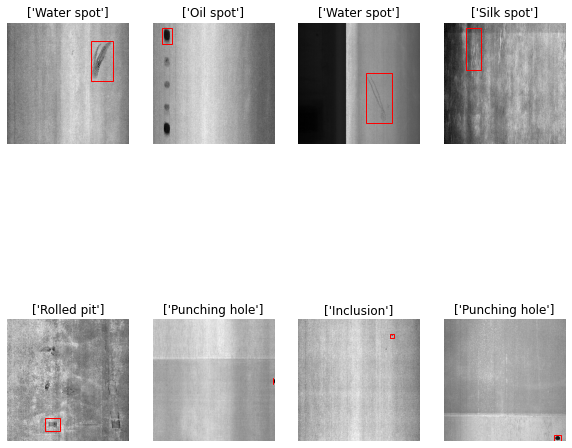

In [25]:
# Display a sample training image with its label
pyplot.figure(figsize=(10, 10))

for img,label in train_dataset.take(1):
  for i in range(8):

    ax = pyplot.subplot(2, 4, i + 1)    
    plt.imshow(keras.preprocessing.image.array_to_img(img[i]))     
    out1, out2, out3, out4, out5 = label                         
    xmin, ymin, xmax, ymax = out1[i].numpy()*224, out2[i].numpy()*224, out3[i].numpy()*224, out4[i].numpy()*224
    rect = Rectangle((xmin,ymin),(xmax - xmin),(ymax - ymin), fill = False, color = "r")  
    ax = plt.gca()                      
    ax.axes.add_patch(rect)   
    pred_imglist = []
    pred_imglist.append(class_dict[np.argmax(out5[i])+1])
    plt.title(pred_imglist)
    pyplot.axis("off")

    #plt.show()

**i. VGG16**

In [26]:
# Import VGG16 model with pre-trained weights from ImageNet

base_vgg16 = tf.keras.applications.VGG16(weights = "imagenet",
                                         include_top = False,
                                         input_shape = (224,224,3),
                                         pooling = 'avg')

In [27]:
# Train only  fully-connected layers
base_vgg16.trainable = False

In [28]:
# Define the base model with fully-connected layers
inputs = keras.Input(shape = (224,224,3))
x = base_vgg16(inputs)

x1 = keras.layers.Dense(1024, activation = "relu")(x)
x1 = keras.layers.Dense(512, activation = "relu")(x1)
out1 = keras.layers.Dense(1, name = "xmin")(x1)
out2 = keras.layers.Dense(1, name = "ymin")(x1)
out3 = keras.layers.Dense(1, name = "xmax")(x1)
out4 = keras.layers.Dense(1, name = "ymax")(x1)

x2 = keras.layers.Dense(1024,activation = "relu")(x)
x2 = keras.layers.Dense(512,activation = "relu")(x2)
out_class = keras.layers.Dense(10,activation = "softmax", name = "class")(x2)

out = [out1, out2, out3, out4, out_class]

vgg16 = keras.models.Model(inputs = inputs, outputs = out)
vgg16.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 512)          14714688    input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         525312      vgg16[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1024)         525312      vgg16[0][0]                      
______________________________________________________________________________________________

In [29]:
# Compile the model with optimizer and loss functions

vgg16.compile(keras.optimizers.Adam(0.0005),
              loss = {"xmin": "mse",
                      "ymin": "mse",
                      "xmax": "mse",
                      "ymax": "mse",
                      "class": "categorical_crossentropy"},
              metrics = ["mae","acc"])

In [30]:
# Reduce learning rate

#lr_reduce = keras.callbacks.ReduceLROnPlateau("val_loss", patience = 5, factor = 0.5, min_lr = 1e-6)

In [31]:
# Start training the model
#callbacks = [lr_reduce]
history = vgg16.fit(train_dataset,
                    steps_per_epoch = train_count//batch_size,
                    batch_size=batch_size,
                    epochs = 20,
                    validation_data = test_dataset,
                    validation_steps = test_count//batch_size)

Epoch 1/20
114/114 [==============================] - 128s 1s/step - loss: 2.2913 - xmin_loss: 0.1019 - ymin_loss: 0.0779 - xmax_loss: 0.0886 - ymax_loss: 0.0938 - class_loss: 1.9290 - xmin_mae: 0.2687 - xmin_acc: 0.0000e+00 - ymin_mae: 0.2267 - ymin_acc: 0.0000e+00 - xmax_mae: 0.2435 - xmax_acc: 0.0724 - ymax_mae: 0.2594 - ymax_acc: 0.0609 - class_mae: 0.1611 - class_acc: 0.3224 - val_loss: 1.7830 - val_xmin_loss: 0.0660 - val_ymin_loss: 0.0776 - val_xmax_loss: 0.0642 - val_ymax_loss: 0.0693 - val_class_loss: 1.5058 - val_xmin_mae: 0.2063 - val_xmin_acc: 0.0000e+00 - val_ymin_mae: 0.2539 - val_ymin_acc: 0.0000e+00 - val_xmax_mae: 0.2106 - val_xmax_acc: 0.1161 - val_ymax_mae: 0.1997 - val_ymax_acc: 0.1228 - val_class_mae: 0.1458 - val_class_acc: 0.5000
Epoch 2/20
114/114 [==============================] - 119s 1s/step - loss: 1.9473 - xmin_loss: 0.0849 - ymin_loss: 0.0758 - xmax_loss: 0.0830 - ymax_loss: 0.0783 - class_loss: 1.6252 - xmin_mae: 0.2460 - xmin_acc: 0.0000e+00 - ymin_mae: 

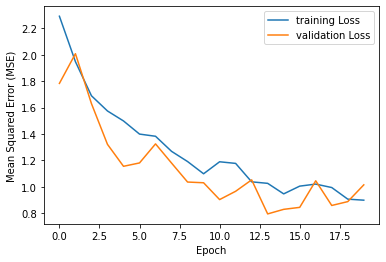

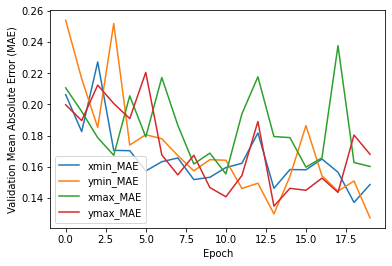

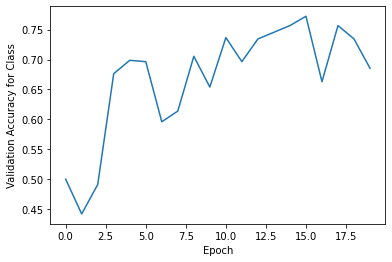

In [32]:
# Visualize the results after training

def plot_history(history):                
    hist = pd.DataFrame(history.history)           
    hist["epoch"] = history.epoch
    
    plt.figure()                                     
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error (MSE)")               
    plt.plot(hist["epoch"], hist["loss"], label = "training Loss")
    plt.plot(hist["epoch"], hist["val_loss"], label = "validation Loss")                           
    plt.legend()
    
    plt.figure()                                      
    plt.xlabel("Epoch")
    plt.ylabel("Validation Mean Absolute Error (MAE)")               
    plt.plot(hist["epoch"], hist["val_xmin_mae"], label = "xmin_MAE")
    plt.plot(hist["epoch"], hist["val_ymin_mae"], label = "ymin_MAE")
    plt.plot(hist["epoch"], hist["val_xmax_mae"], label = "xmax_MAE")
    plt.plot(hist["epoch"], hist["val_ymax_mae"], label = "ymax_MAE")
    plt.legend()      
    
    plt.figure()                                      
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy for Class")               
    plt.plot(hist["epoch"],hist["val_class_acc"], label = "class_accuracy")
    
    plt.show()
    
plot_history(history)  

In [33]:
results = vgg16.evaluate(test_dataset)

456/456 [==============================] - 1115s 2s/step - loss: 1.0796 - xmin_loss: 0.0515 - ymin_loss: 0.0339 - xmax_loss: 0.0448 - ymax_loss: 0.0511 - class_loss: 0.8983 - xmin_mae: 0.1643 - xmin_acc: 0.0000e+00 - ymin_mae: 0.1457 - ymin_acc: 0.0000e+00 - xmax_mae: 0.1677 - xmax_acc: 0.0894 - ymax_mae: 0.1859 - ymax_acc: 0.0758 - class_mae: 0.0756 - class_acc: 0.6601


In [34]:
print("MAE of xmin value in test set:{}".format(results[6]))
print("MAE of ymin value in test set:{}".format(results[8]))
print("MAE of xmax value in test set:{}".format(results[10]))
print("MAE of ymax value in test set:{}".format(results[12]))
print("Testing accuracy of predicted label:{}".format(results[15]))

MAE of xmin value in test set:0.16433674097061157
MAE of ymin value in test set:0.14571498334407806
MAE of xmax value in test set:0.1677209436893463
MAE of ymax value in test set:0.18592484295368195
Testing accuracy of predicted label:0.6600877046585083


In [35]:
#vgg16.save("vgg16.h5")

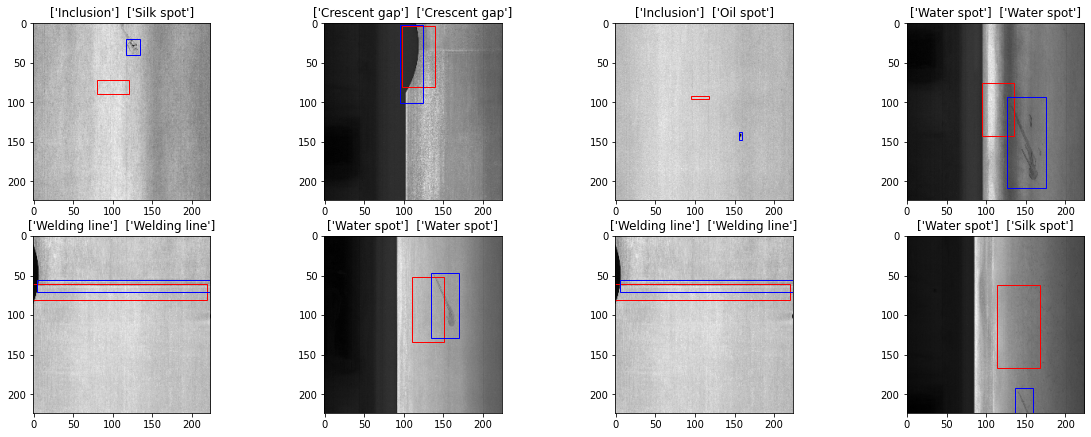

In [43]:
# generate random integer values
from random import seed
from random import randint
seed(1)

plt.figure(figsize = (20, 15))
for img, GT in test_dataset.take(1):
    out1, out2, out3, out4, out5 = vgg16.predict(img)
    out1_gt, out2_gt, out3_gt, out4_gt, out5_gt = GT                         

    for i in range(8):
        num=randint(0, batch_size)
        plt.subplot(4, 4, i + 1)            
        plt.imshow(keras.preprocessing.image.array_to_img(img[num]))    
        pred_imglist = []
        pred_imglist.append(class_dict[np.argmax(out5[num]) + 1])

        gt_list=[]
        gt_list.append(class_dict[np.argmax(out5_gt[num]) + 1])
        plt.title('{0}  {1}'.format(gt_list, pred_imglist))

        xmin, ymin, xmax, ymax = out1[num]*224, out2[num]*224, out3[num]*224, out4[num]*224
        rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r") 

        xmin, ymin, xmax, ymax = out1_gt[num]*224, out2_gt[num]*224, out3_gt[num]*224, out4_gt[num]*224
        rect2 = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "b") 

        ax = plt.gca()                   
        ax.axes.add_patch(rect)
        ax.axes.add_patch(rect2)

In [44]:
# Append all the true labels into a list

true_labels = []

for _, label in test_dataset:    
    out1, out2, out3, out4, out5 = label                              
    true_labels.append(class_dict[np.argmax(out5) + 1])

In [45]:
#true_labels

In [46]:

test_labels = []

for img, label in test_dataset:
    out1, out2, out3, out4, out5 = label
    label = vgg16.predict(img)
    test_labels.append(class_dict[np.argmax(out5) + 1])

In [47]:
#test_labels

In [48]:
target_names = ['Cresent gap', 'Crease', 'Silk spot', 'Water spot', 'Welding line', 
                'Inclusion', 'Oil spot', 'Waist folding', 'Rolled pit', 'Punching hole']

In [49]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, test_labels, target_names = target_names))

               precision    recall  f1-score   support

  Cresent gap       0.00      0.00      0.00         7
       Crease       0.09      0.12      0.10        34
    Silk spot       0.10      0.09      0.09        46
   Water spot       0.09      0.09      0.09        32
 Welding line       0.14      0.15      0.15        39
    Inclusion       0.00      0.00      0.00         5
     Oil spot       0.27      0.27      0.27       135
Waist folding       0.07      0.07      0.07        29
   Rolled pit       0.19      0.19      0.19        68
Punching hole       0.14      0.13      0.14        61

     accuracy                           0.17       456
    macro avg       0.11      0.11      0.11       456
 weighted avg       0.17      0.17      0.17       456



In [50]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_labels, test_labels, labels = target_names)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  1,  0,  0,  2,  1,  0,  0],
       [ 0,  2, 36, 24, 11, 14,  7, 10,  0, 16],
       [ 0,  1, 24, 13,  8,  8,  1,  1,  2,  6],
       [ 0,  3, 14, 10,  8,  4, 10,  4,  1,  4],
       [ 0,  0, 20,  3,  8,  4,  1,  1,  1,  6],
       [ 0,  1,  9,  6,  3,  3,  3,  3,  1,  0],
       [ 0,  0,  8,  4,  3,  1,  3,  2,  1,  1],
       [ 0,  0,  0,  0,  1,  0,  1,  1,  0,  1],
       [ 0,  0,  3,  4, 10,  3,  1,  5,  0,  6]], dtype=int64)